In [1]:
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/home/vincentv/dtaijupiter/maintained_repositories/anomatools/')

# Generate data

Generate a small toy dataset from 3 multivariate Gaussians. Plot the data.

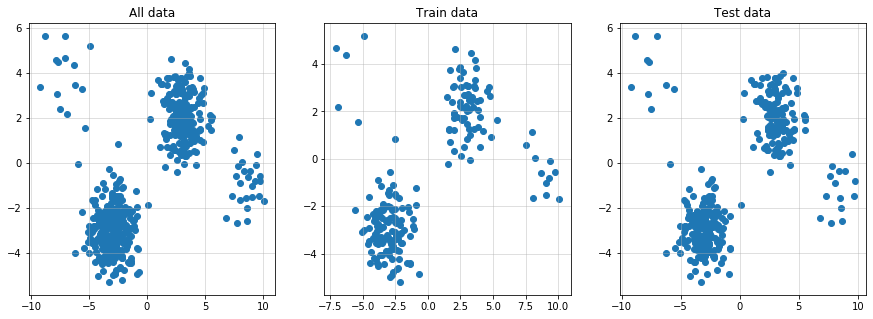

In [9]:
np.random.seed(42)
X = np.vstack((np.random.multivariate_normal([-3, -3], [[1, 0], [0, 1]], 300),
               np.random.multivariate_normal([3, 2], [[1, 0], [0, 1]], 200),
               np.random.multivariate_normal([8, -1], [[1, 0], [0, 1]], 25),
               np.random.multivariate_normal([-7, 4], [[2, 0], [0, 2]], 15)))
np.random.shuffle(X)
X_train, X_test = X[:200, :], X[200:, :]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(X[:, 0], X[:, 1]); axes[0].set_title('All data')
axes[1].scatter(X_train[:, 0], X_train[:, 1]); axes[1].set_title('Train data')
axes[2].scatter(X_test[:, 0], X_test[:, 1]); axes[2].set_title('Test data')
for i in range(len(axes)): axes[i].grid(alpha=0.5)

We can clearly see the three clusters in the data. Let's call them: cluster 1, 2, and 3 for respectively the cluster with 100, 50, and 10 instances.

# Test SSDO

In [8]:
from anomatools.models import SSDO
from sklearn.ensemble import IsolationForest

### Pure Isolation Forest

Contamination = 0.2
TRAIN set anomalies: Counter({1: 160, -1: 40}) ; expected = 40
TEST set anomalies: Counter({1: 272, -1: 68}) ; expected = 68


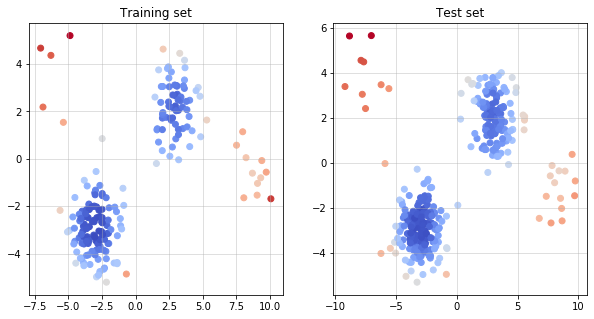

In [19]:
c = 0.2
print('Contamination =', c)

Xtr = X_train.copy()
Xte = X_test.copy()

# iForest
prior_detector = IsolationForest(n_estimators=100, contamination=c, behaviour='new')
prior_detector.fit(Xtr)
tr_prior = prior_detector.decision_function(Xtr) * -1
te_prior = prior_detector.decision_function(Xte) * -1

# iForest predictions
tr_pred = prior_detector.predict(Xtr)
te_pred = prior_detector.predict(Xte)
print('TRAIN set anomalies:', Counter(tr_pred), '; expected =', int(c * len(Xtr)))
print('TEST set anomalies:', Counter(te_pred), '; expected =', int(c * len(Xte)))

# plot
color_code = {0: 'black', 1: 'red', -1: 'blue'}
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(Xtr[:, 0], Xtr[:, 1], c=tr_prior, cmap=plt.cm.coolwarm); axes[0].set_title('Training set')
axes[1].scatter(Xte[:, 0], Xte[:, 1], c=te_prior, cmap=plt.cm.coolwarm); axes[1].set_title('Test set')
for i in range(len(axes)): axes[i].grid(alpha=0.5)

### Isolation Forest and SSDO

Contamination = 0.1
Labeled = 50
TRAIN set anomalies: Counter({-1: 180, 1: 20}) ; expected = 20
TEST set anomalies: Counter({-1: 303, 1: 37}) ; expected = 34


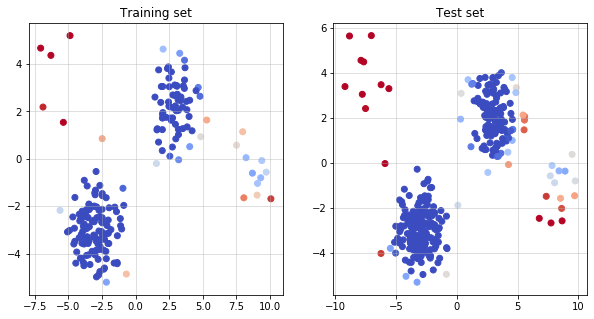

In [37]:
Xtr = X_train.copy()
Xte = X_test.copy()


c = 0.1
print('Contamination =', c)
y = np.zeros(len(Xtr), dtype=int)
y[:50] = -1
print('Labeled =', len(np.where(y != 0)[0]))

# iForest
prior_detector = IsolationForest(n_estimators=100, contamination=c, behaviour='new')
prior_detector.fit(Xtr)
tr_prior = prior_detector.decision_function(Xtr) * -1
te_prior = prior_detector.decision_function(Xte) * -1
tr_prior = tr_prior + abs(min(tr_prior))
te_prior = te_prior + abs(min(te_prior))

# SSDO
detector = SSDO(k=30, alpha=2.3, unsupervised_prior='other', contamination=c)
tr_pred = detector.fit_predict(Xtr, y, prior=tr_prior)
tr_prob = detector.predict_proba(Xtr, prior=tr_prior, method='unify')[:, 1]
te_pred = detector.predict(Xte, prior=te_prior)
te_prob = detector.predict_proba(Xte, prior=te_prior, method='unify')[:, 1]  # anomaly probabilities

print('TRAIN set anomalies:', Counter(tr_pred), '; expected =', int(c * len(Xtr)))
print('TEST set anomalies:', Counter(te_pred), '; expected =', int(c * len(Xte)))

# plot
color_code = {0: 'black', 1: 'red', -1: 'blue'}
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(Xtr[:, 0], Xtr[:, 1], c=tr_prob, cmap=plt.cm.coolwarm); axes[0].set_title('Training set')
axes[1].scatter(Xte[:, 0], Xte[:, 1], c=te_prob, cmap=plt.cm.coolwarm); axes[1].set_title('Test set')
for i in range(len(axes)): axes[i].grid(alpha=0.5)

# Detect outliers

## SSkNNO

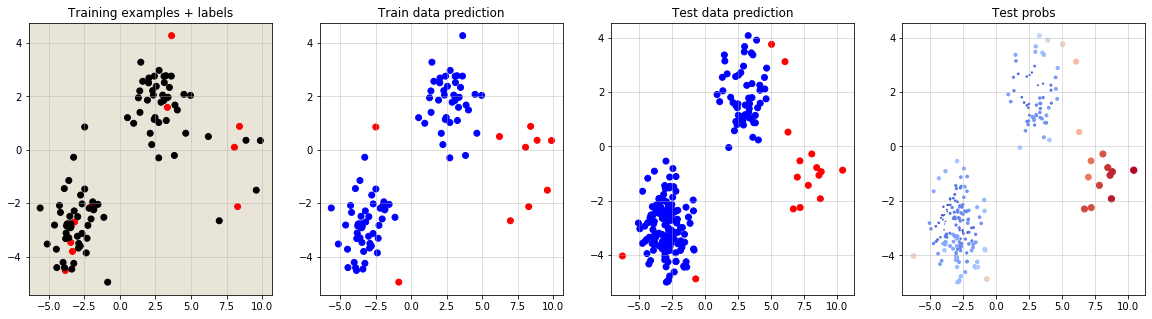

In [18]:
from anomatools.models import SSkNNO

# labels
y = np.zeros(len(Xtr))
y[:10] = 1

detector = SSkNNO(k=10, contamination=0.1, weighted=False)
ytr = detector.fit_predict(Xtr, y)
yte = detector.predict(Xte)
test_probs = detector.predict_proba(Xte, method='linear')[:, 1]  # anomaly probabilities

# plot the predictions
color_code = {0: 'black', 1: 'red', -1: 'blue'}
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].scatter(Xtr[:, 0], Xtr[:, 1], c=[color_code[i] for i in y]); axes[0].set_title('Training examples + labels'); axes[0].set_facecolor('#e8e4d8')
axes[1].scatter(Xtr[:, 0], Xtr[:, 1], c=[color_code[i] for i in ytr]); axes[1].set_title('Train data prediction')
axes[2].scatter(Xte[:, 0], Xte[:, 1], c=[color_code[i] for i in yte]); axes[2].set_title('Test data prediction')
axes[3].scatter(Xte[:, 0], Xte[:, 1], s=test_probs*40, c=test_probs, cmap=plt.cm.coolwarm); axes[3].set_title('Test probs')
for i in range(len(axes)): axes[i].grid(alpha=0.5)

## SSDO

### SSDO with SSDO prior

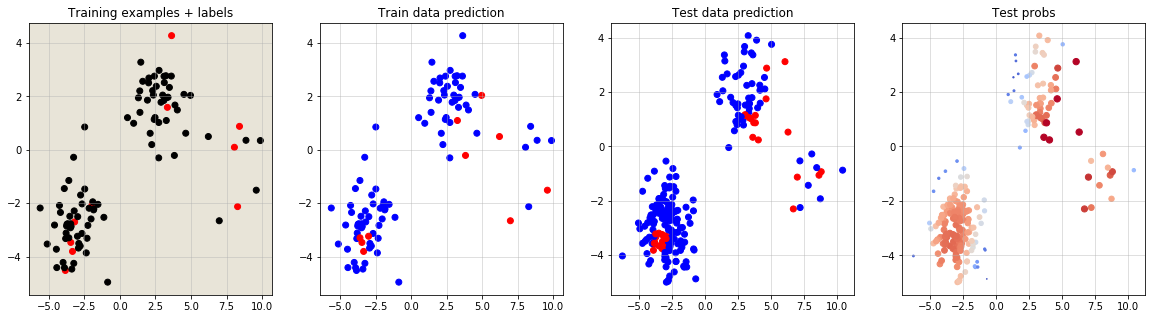

In [24]:
from anomatools.models import SSDO

# labels
y = np.zeros(len(Xtr))
y[:10] = 1

detector = SSDO(k=10, alpha=2.3)
ytr = detector.fit_predict(Xtr, y)
yte = detector.predict(Xte)
test_probs = detector.predict_proba(Xte, method='linear')[:, 1]  # anomaly probabilities

# plot the predictions
color_code = {0: 'black', 1: 'red', -1: 'blue'}
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].scatter(Xtr[:, 0], Xtr[:, 1], c=[color_code[i] for i in y]); axes[0].set_title('Training examples + labels'); axes[0].set_facecolor('#e8e4d8')
axes[1].scatter(Xtr[:, 0], Xtr[:, 1], c=[color_code[i] for i in ytr]); axes[1].set_title('Train data prediction')
axes[2].scatter(Xte[:, 0], Xte[:, 1], c=[color_code[i] for i in yte]); axes[2].set_title('Test data prediction')
axes[3].scatter(Xte[:, 0], Xte[:, 1], s=test_probs*40, c=test_probs, cmap=plt.cm.coolwarm); axes[3].set_title('Test probs')
for i in range(len(axes)): axes[i].grid(alpha=0.5)

### SSDO with Isolation Forest prior

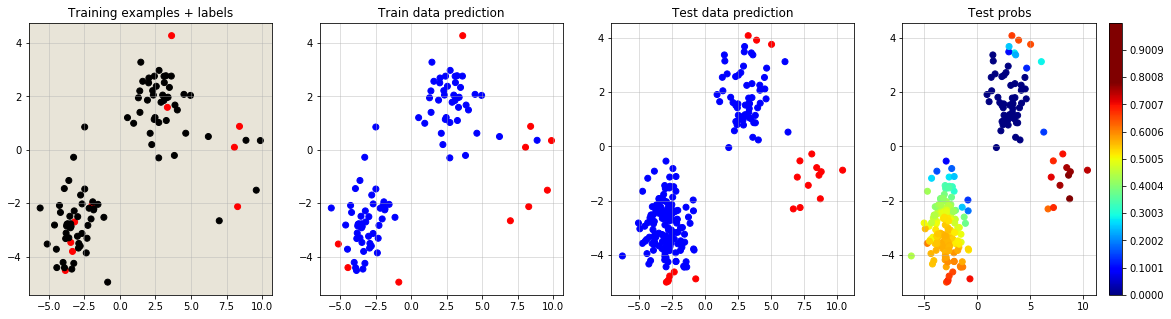

In [157]:
from anomatools.models import SSDO
from sklearn.ensemble import IsolationForest

# labels
y = np.zeros(len(Xtr))
y[:10] = 1

# priors
prior_detector = IsolationForest(contamination=0.1, behaviour='new').fit(Xtr)
train_prior = prior_detector.decision_function(Xtr) * -1
test_prior = prior_detector.decision_function(Xte) * -1
train_prior = train_prior + abs(min(train_prior))
test_prior = test_prior + abs(min(test_prior))

# SSDO
detector = SSDO(k=30, alpha=2.3, unsupervised_prior='other')
ytr = detector.fit_predict(Xtr, y, prior=train_prior)
train_scores = detector.scores_
train_probs = detector.predict_proba(Xtr, prior=train_prior, method='unify')[:, 1]

test_scores = detector.decision_function(Xte, prior=test_prior)
yte = detector.predict(Xte, prior=test_prior)
test_probs = detector.predict_proba(Xte, prior=test_prior, method='unify')[:, 1]  # anomaly probabilities

# plot the predictions
color_code = {0: 'black', 1: 'red', -1: 'blue'}
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].scatter(Xtr[:, 0], Xtr[:, 1], c=[color_code[i] for i in y]); axes[0].set_title('Training examples + labels'); axes[0].set_facecolor('#e8e4d8')
axes[1].scatter(Xtr[:, 0], Xtr[:, 1], c=[color_code[i] for i in ytr]); axes[1].set_title('Train data prediction')
axes[2].scatter(Xte[:, 0], Xte[:, 1], c=[color_code[i] for i in yte]); axes[2].set_title('Test data prediction')
cp = axes[3].scatter(Xte[:, 0], Xte[:, 1], c=test_probs, cmap=plt.cm.jet); axes[3].set_title('Test probs')
for i in range(len(axes)): axes[i].grid(alpha=0.5)
plt.colorbar(cp, boundaries=np.linspace(0, 1, 1000))

Counter({-1: 90, 1: 10}) Counter({-1: 200, 1: 20}) 0.9148606691844028


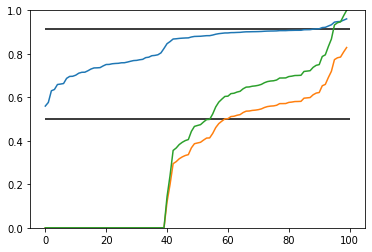

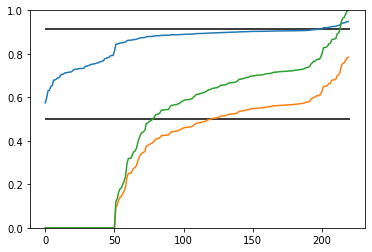

In [158]:
print(Counter(ytr), Counter(yte), detector.threshold_)
plt.figure()
plt.plot(sorted(train_scores))
plt.plot(sorted(train_probs))
plt.plot((sorted(train_probs) - min(train_probs)) / (max(train_probs) - min(train_probs)))
plt.ylim([0.0, 1.0])
plt.hlines(detector.threshold_, 0, len(train_probs))
plt.hlines(0.5, 0, len(train_probs))

plt.figure()
plt.plot(sorted(test_scores))
plt.plot(sorted(test_probs))
plt.plot((sorted(test_probs) - min(test_probs)) / (max(test_probs) - min(test_probs)))
plt.ylim([0.0, 1.0])
plt.hlines(detector.threshold_, 0, len(test_probs))
plt.hlines(0.5, 0, len(test_probs))

### SSDO visualizations

In [26]:
from anomatools.utils.plotting import *

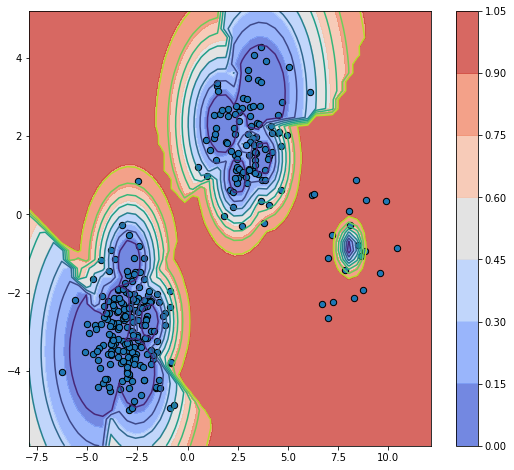

In [40]:
# SSDO
detector = SSDO(n_clusters=10, k=10, contamination=0.1, unsupervised_prior='ssdo')
plot_2D_classifier(detector, X, np.zeros(len(X)), figure_size=(9, 8))